In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage


In [3]:
sns.set(style="whitegrid")

import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/subhadeep-123/KMeans-and-Agglomerative-Clustering-on-Mall-Customers-dataset/master/Mall_Customers.csv")
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
                        count    mean        std   min    25%    50%     75%  \
CustomerID              200.0  100.50  57.879185   1.0  50.75  100.5  150.25   
Age                     200.0   38.85  13.969007  18.0  28.75   36.0   49.00   
Annual Income (k$)      200.0   60.56  26.264721  15.0  41.50   61.5   78.00   
Spending Score (1-100)  200.0   50.20  25.823522   1.0  34.75   50.0   73.00   

                          max  
CustomerID              200.0  
Age         

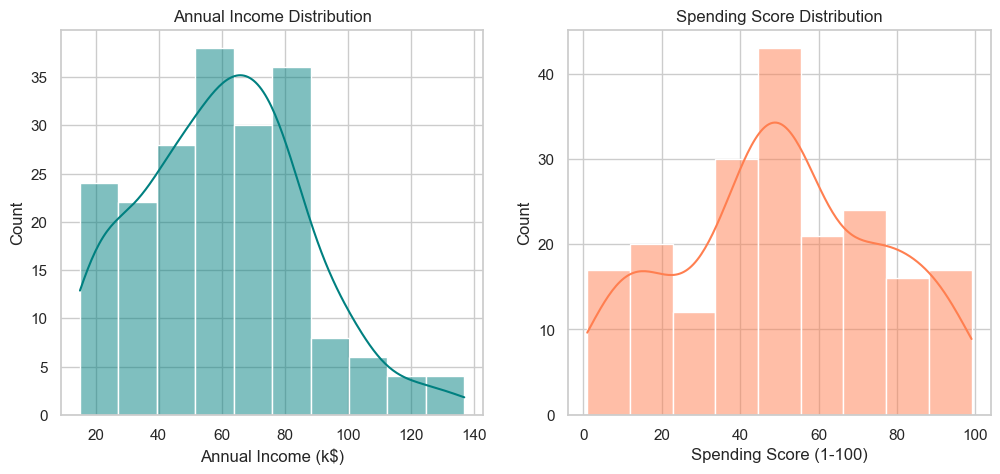

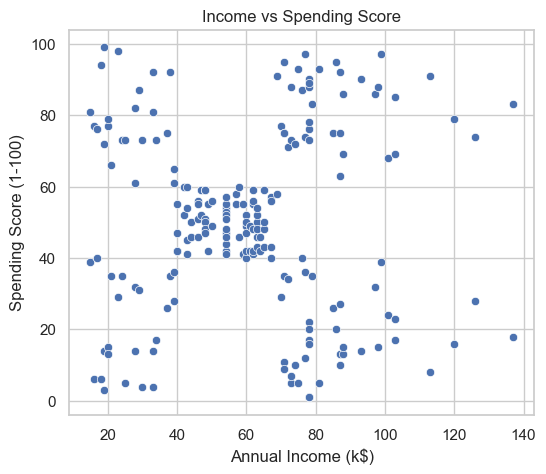

In [4]:
print(df.info())
print(df.describe().T)
print("\nMissing values:\n", df.isnull().sum())

# Quick visual analysis
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['Annual Income (k$)'], kde=True, color='teal')
plt.title('Annual Income Distribution')

plt.subplot(1,2,2)
sns.histplot(df['Spending Score (1-100)'], kde=True, color='coral')
plt.title('Spending Score Distribution')
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df)
plt.title('Income vs Spending Score')
plt.show()


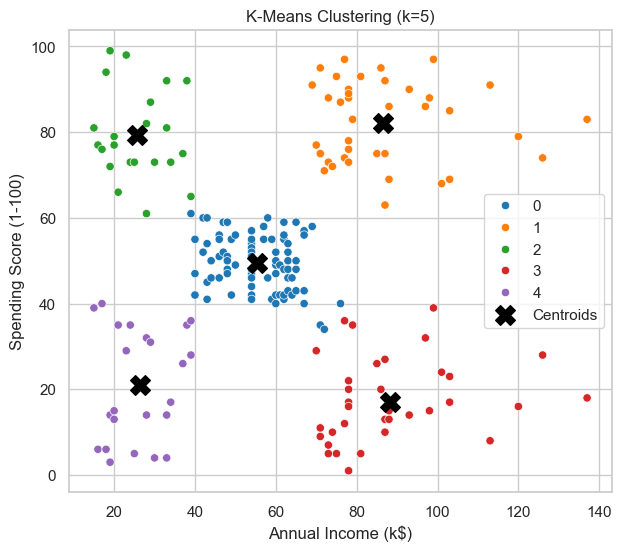

In [5]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means (initial)
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X['Annual Income (k$)'], y=X['Spending Score (1-100)'], hue=labels, palette='tab10')
plt.scatter(scaler.inverse_transform(kmeans.cluster_centers_)[:,0],
            scaler.inverse_transform(kmeans.cluster_centers_)[:,1],
            c='black', s=200, marker='X', label='Centroids')
plt.title('K-Means Clustering (k=5)')
plt.legend()
plt.show()


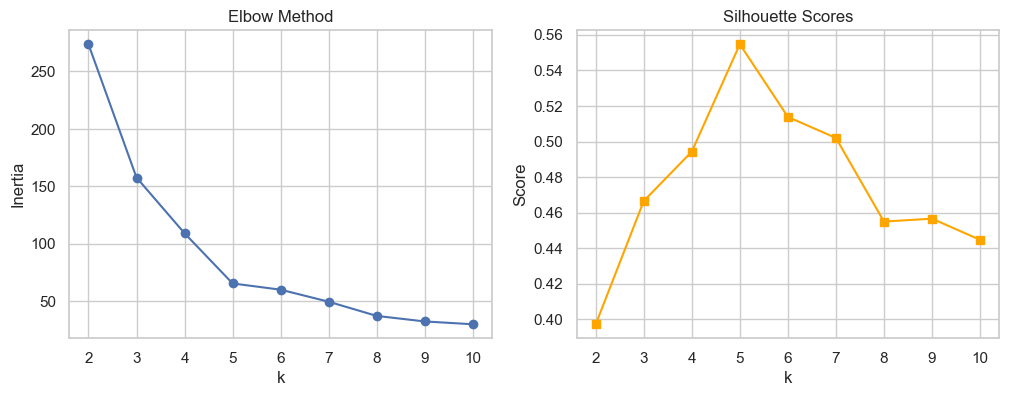

In [6]:
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, km.labels_))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K, inertia, 'o-')
plt.title('Elbow Method')
plt.xlabel('k'); plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, 's-', color='orange')
plt.title('Silhouette Scores')
plt.xlabel('k'); plt.ylabel('Score')
plt.show()


In [7]:
optimal_k = 5  # choose based on elbow/silhouette observation
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = final_kmeans.fit_predict(X_scaled)

profile = df.groupby('Cluster')[['Annual Income (k$)','Spending Score (1-100)']].mean().round(2)
profile['Count'] = df['Cluster'].value_counts().sort_index().values
profile


,Annual Income (k$),Spending Score (1-100),Count
Cluster,,,
0,55.30,49.52,81
1,86.54,82.13,39
2,25.73,79.36,22
3,88.20,17.11,35
4,26.30,20.91,23


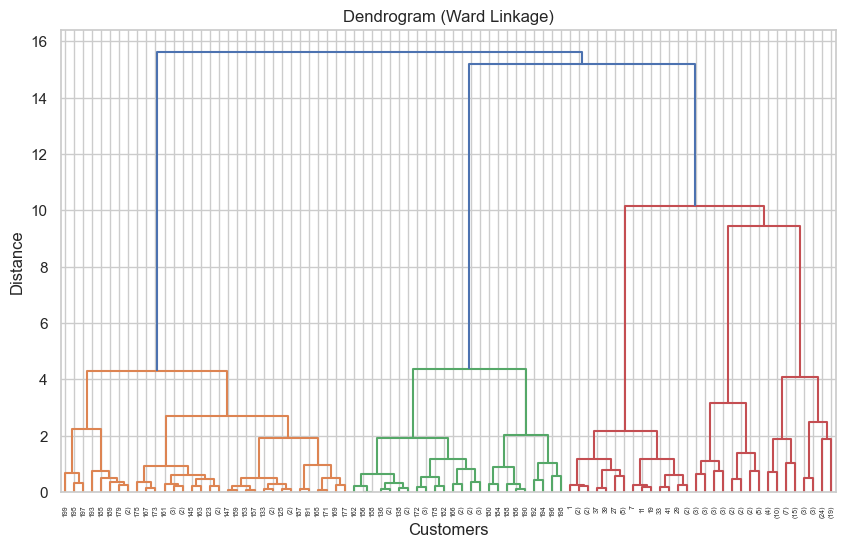

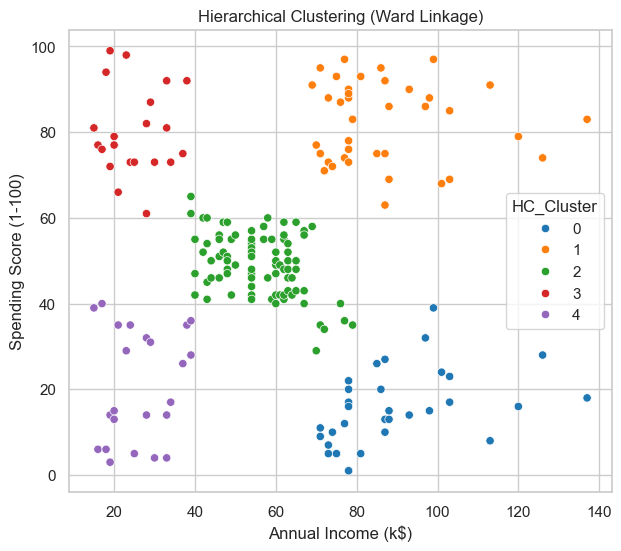

In [9]:
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10,6))
dendrogram(linked, truncate_mode='level', p=6)
plt.title('Dendrogram (Ward Linkage)')
plt.xlabel('Customers')
plt.ylabel('Distance')
plt.show()

hc = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
df['HC_Cluster'] = hc.fit_predict(X_scaled)

plt.figure(figsize=(7,6))
# Pass the DataFrame and use the column name for hue
sns.scatterplot(data=df,
                x='Annual Income (k$)',
                y='Spending Score (1-100)',
                hue='HC_Cluster',
                palette='tab10')
plt.title('Hierarchical Clustering (Ward Linkage)')
plt.show()


In [10]:
sil_kmeans = silhouette_score(X_scaled, df['Cluster'])
db_kmeans = davies_bouldin_score(X_scaled, df['Cluster'])

sil_hc = silhouette_score(X_scaled, df['HC_Cluster'])
db_hc = davies_bouldin_score(X_scaled, df['HC_Cluster'])

comparison = pd.DataFrame({
    'Algorithm': ['K-Means', 'Hierarchical'],
    'Silhouette Score': [sil_kmeans, sil_hc],
    'Davies-Bouldin Index': [db_kmeans, db_hc]
})
comparison


,Algorithm,Silhouette Score,Davies-Bouldin Index
0,K-Means,0.554657,0.572236
1,Hierarchical,0.553809,0.577862


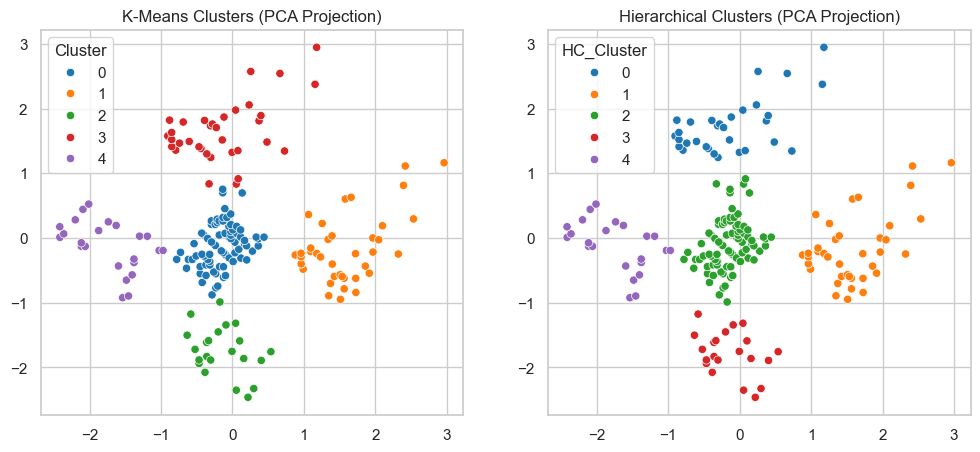

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette='tab10')
plt.title('K-Means Clusters (PCA Projection)')

plt.subplot(1,2,2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['HC_Cluster'], palette='tab10')
plt.title('Hierarchical Clusters (PCA Projection)')
plt.show()


In [12]:
print("=== Final Analysis ===\n")
print(f"K-Means: Silhouette = {sil_kmeans:.3f}, Davies-Bouldin = {db_kmeans:.3f}")
print(f"Hierarchical: Silhouette = {sil_hc:.3f}, Davies-Bouldin = {db_hc:.3f}\n")

print("Insights:")
print("""
- Both algorithms form clear customer segments.
- K-Means is more compact and faster for large data.
- Hierarchical gives better interpretability through the dendrogram.
- Clusters reveal patterns like High Income–High Spending and Low Income–Low Spending.
- Ideal for marketing strategy targeting specific spending behaviors.
""")


=== Final Analysis ===

K-Means: Silhouette = 0.555, Davies-Bouldin = 0.572
Hierarchical: Silhouette = 0.554, Davies-Bouldin = 0.578

Insights:

- Both algorithms form clear customer segments.
- K-Means is more compact and faster for large data.
- Hierarchical gives better interpretability through the dendrogram.
- Clusters reveal patterns like High Income–High Spending and Low Income–Low Spending.
- Ideal for marketing strategy targeting specific spending behaviors.

